In [ ]:
%pip install transformers datasets peft wandb

In [1]:
import transformers
import datasets 
import peft

In [65]:
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, DatasetDict

lora_config = LoraConfig(
    r=4, # number of the parameters to train.
    lora_alpha=1, # magnitude of the weight matrix
    target_modules=["query", "value"],
    lora_dropout=0.05,
    bias="lora_only",
    task_type="SEQ_CLS" # sequence classification
)

In [3]:
from transformers import BertTokenizer, BertModel
model_checkpoint = "google-bert/bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_checkpoint, use_fast=True)
foundation_model = BertModel.from_pretrained(model_checkpoint)

In [ ]:
import pandas as pd

DATA_PATH = "/home/jovyan/work/ULM-25-authorship-profiling/data/"

df_train = pd.read_csv(DATA_PATH + "data_train.csv")
df_test = pd.read_csv(DATA_PATH + "data_test.csv")
df_val = pd.read_csv(DATA_PATH + "data_val.csv")

In [ ]:
dataset = DatasetDict()
dataset['train'] = Dataset.from_pandas(df_train)
dataset['validation'] = Dataset.from_pandas(df_val)
dataset['test'] = Dataset.from_pandas(df_test)

In [ ]:
dataset = dataset.filter(lambda example: 
                         example["text"] is not None and 
                         example["gender"] is not None and
                         example ["age"] is not None)
dataset

In [6]:
from transformers import AutoTokenizer, AutoModel, PreTrainedModel, PretrainedConfig
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
import numpy as np


def preprocess_function(examples):
    tokenized = tokenizer(
        examples['text'],
        truncation=True,
        padding='max_length',
        max_length=512
    )
    gender_labels = [
        {"male": 0, "female": 1}[label] for label in examples["gender"]
    ]
    return {
        "input_ids": tokenized["input_ids"],
        "attention_mask": tokenized["attention_mask"],
        "age_labels": examples["age"],
        "gender_labels": gender_labels,
        "labels": np.stack([examples["age"], gender_labels], axis=1)
    }

In [ ]:
tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['text', 'age', 'gender']
)

In [ ]:
tokenized_dataset

In [ ]:
from huggingface_hub import login
login()

In [ ]:
tokenized_dataset.push_to_hub(
    "KonradBRG/ULM-Profiling-tokenized",
    private=False,  # or True if you want it private
    commit_message="Upload tokenized ULM profiling dataset"
)

In [4]:
from datasets import load_dataset
tokenized_dataset = load_dataset("KonradBRG/ULM-Profiling-tokenized")

In [7]:
class JointClassificationConfig(PretrainedConfig):
    def __init__(self, num_age_labels=None, num_gender_labels=None, loss_alpha=0.5, **kwargs):
        super().__init__(**kwargs)
        self.num_age_labels = num_age_labels
        self.num_gender_labels = num_gender_labels

In [8]:
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.nn import CrossEntropyLoss

class BertForJointClassification(PreTrainedModel):
    config_class = JointClassificationConfig
    
    def __init__(self, config, model):
        super().__init__(config)
        self.num_age_labels = config.num_age_labels
        self.num_gender_labels = config.num_gender_labels

        self.bert = model
        self.age_classifier = nn.Linear(config.hidden_size, self.num_age_labels)
        self.gender_classifier = nn.Linear(config.hidden_size, self.num_gender_labels)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.age_loss_fct = CrossEntropyLoss()
        self.gender_loss_fct = CrossEntropyLoss()
        
        self.init_weights()

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        age_labels=None,
        gender_labels=None,
        **kwargs
    ):
        # get BERT outputs
        x = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )
        # pool outputs to get sequence representation
        x = x.last_hidden_state[:, 0]
        x = self.dropout(x)
        # get logits from task head
        age_logits = self.age_classifier(x)
        gender_logits = self.gender_classifier(x)
        loss_age = self.age_loss_fct(age_logits, age_labels)
        loss_gender = self.gender_loss_fct(gender_logits, gender_labels)
        return SequenceClassifierOutput(loss={"loss_age": loss_age, "loss_gender": loss_gender}, 
                                        logits=torch.cat([age_logits, gender_logits], dim=1))

In [19]:
num_age_labels = len([0, 18, 23, 27, 33, 37, 43, 47, 53, 57, 100])
def setup_model(dataset, model_name="bert-base-uncased", peft=True):
    config = JointClassificationConfig(
        name_or_path=model_name,
        num_age_labels=num_age_labels,
        num_gender_labels=2,
        hidden_size=768,
        hidden_dropout_prob=0.1,
    )
    bert = BertForJointClassification(config, foundation_model)
    if peft:
        bert = get_peft_model(bert, lora_config)
    return bert, config, dataset

In [71]:
# optional
peft_model.unload()

BertForJointClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [72]:
peft_model, config, data = setup_model(tokenized_dataset, model_checkpoint)

In [73]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

def compute_metrics(eval_pred):
    """
    Enhanced compute_metrics function for multi-task learning (age + gender prediction)
    Returns comprehensive metrics including accuracy, precision, recall, and F1-score
    """
    logits = eval_pred.predictions
    age_labels, gender_labels = eval_pred.label_ids
    
    # Split logits for each task
    age_logits = logits[:, :num_age_labels]
    gender_logits = logits[:, num_age_labels:]
    
    # Get predictions
    age_preds = np.argmax(age_logits, axis=-1)
    gender_preds = np.argmax(gender_logits, axis=-1)
    
    # === AGE TASK METRICS ===
    age_acc = accuracy_score(age_labels, age_preds)
    age_precision, age_recall, age_f1, _ = precision_recall_fscore_support(
        age_labels, age_preds, average='weighted', zero_division=0
    )
    
    # Macro averages for age (useful for imbalanced classes)
    age_precision_macro, age_recall_macro, age_f1_macro, _ = precision_recall_fscore_support(
        age_labels, age_preds, average='macro', zero_division=0
    )
    
    # === GENDER TASK METRICS ===
    gender_acc = accuracy_score(gender_labels, gender_preds)
    gender_precision, gender_recall, gender_f1, _ = precision_recall_fscore_support(
        gender_labels, gender_preds, average='weighted', zero_division=0
    )
    
    # Macro averages for gender
    gender_precision_macro, gender_recall_macro, gender_f1_macro, _ = precision_recall_fscore_support(
        gender_labels, gender_preds, average='macro', zero_division=0
    )
    
    # === JOINT METRICS ===
    # Joint accuracy (both predictions must be correct)
    joint_acc = np.mean((age_preds == age_labels) & (gender_preds == gender_labels))
    
    # Average metrics across both tasks
    avg_acc = (age_acc + gender_acc) / 2
    avg_precision = (age_precision + gender_precision) / 2
    avg_recall = (age_recall + gender_recall) / 2
    avg_f1 = (age_f1 + gender_f1) / 2
    
    # Macro average metrics across both tasks
    avg_precision_macro = (age_precision_macro + gender_precision_macro) / 2
    avg_recall_macro = (age_recall_macro + gender_recall_macro) / 2
    avg_f1_macro = (age_f1_macro + gender_f1_macro) / 2
    
    return {
        # Age task metrics
        "age_acc": age_acc,
        "age_precision": age_precision,
        "age_recall": age_recall,
        "age_f1": age_f1,
        "age_precision_macro": age_precision_macro,
        "age_recall_macro": age_recall_macro,
        "age_f1_macro": age_f1_macro,
        
        # Gender task metrics
        "gender_acc": gender_acc,
        "gender_precision": gender_precision,
        "gender_recall": gender_recall,
        "gender_f1": gender_f1,
        "gender_precision_macro": gender_precision_macro,
        "gender_recall_macro": gender_recall_macro,
        "gender_f1_macro": gender_f1_macro,
        
        # Joint and average metrics
        "joint_acc": joint_acc,
        "avg_acc": avg_acc,
        "avg_precision": avg_precision,
        "avg_recall": avg_recall,
        "avg_f1": avg_f1,
        "avg_precision_macro": avg_precision_macro,
        "avg_recall_macro": avg_recall_macro,
        "avg_f1_macro": avg_f1_macro,
    }

In [74]:
from typing import Dict, Union, Any
from transformers import Trainer, TrainingArguments, default_data_collator

class TrainerWithCustomLoss(Trainer):
    
    def __init__(self, age_alpha: float = 0.5, scale_losses = True, **kwargs):
        super().__init__(**kwargs)
        self.age_alpha = age_alpha
        self.gender_alpha = 1 - self.age_alpha
        self._scale_losses = scale_losses
    
    def training_step(
        self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]], num_items_in_batch=None
    ) -> torch.Tensor:
        model.train()
        if hasattr(self.optimizer, "train") and callable(self.optimizer.train):
            self.optimizer.train()
        inputs = self._prepare_inputs(inputs)
        
        with self.compute_loss_context_manager():
            loss = self.compute_loss(model, inputs)
        self.accelerator.backward(loss)
        
        # Finally we need to normalize the loss for reporting
        if num_items_in_batch is None:
            return loss.detach() / self.args.gradient_accumulation_steps
        return loss.detach()

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        outputs = model(**inputs)
        loss_age, loss_gender = outputs.loss["loss_age"], outputs.loss["loss_gender"]
        loss = self.age_alpha * loss_age + self.gender_alpha * loss_gender
        
        if return_outputs:
            return loss, outputs
        return loss

In [75]:
del trainer

In [76]:
from transformers import Trainer, TrainingArguments, default_data_collator

print(peft_model.print_trainable_parameters())
log_frequency = 1000

training_args = TrainingArguments(
    "bert-lora-for-author-profiling",
    per_device_train_batch_size=16,  # Set explicitly for better control
    gradient_accumulation_steps=2,   # Effective batch size = 32 * 2 = 64
    num_train_epochs=2,
    # Speed optimizations
    dataloader_num_workers=4,        # Parallel data loading
    dataloader_pin_memory=True,      # Faster GPU transfer
    bf16=True,                       # Mixed precision (if you have newer GPU)
    # fp16=True,                     # Use this instead if bf16 not supported
    # Reduce overhead
    eval_strategy="steps",           # Less frequent evaluation
    eval_steps=1000,                  # Adjust based on dataset size
    logging_strategy="steps",
    logging_steps=log_frequency,
    save_strategy="no",
    learning_rate=0.000097145,
    report_to="wandb"
)

trainer = TrainerWithCustomLoss(
    age_alpha=0.40036,
    model=peft_model,
    args=training_args,
    train_dataset=data['train'].with_format("torch"),
    eval_dataset=data['validation'].with_format("torch"),
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

trainable params: 175,885 || all params: 109,649,690 || trainable%: 0.1604
None


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Age Acc,Age Precision,Age Recall,Age F1,Age Precision Macro,Age Recall Macro,Age F1 Macro,Gender Acc,Gender Precision,Gender Recall,Gender F1,Gender Precision Macro,Gender Recall Macro,Gender F1 Macro,Joint Acc,Avg Acc,Avg Precision,Avg Recall,Avg F1,Avg Precision Macro,Avg Recall Macro,Avg F1 Macro
1000,0.926700,0.869854,0.540070,0.457442,0.540070,0.464227,0.205892,0.203311,0.178317,0.659061,0.659243,0.659061,0.659079,0.659107,0.659142,0.659052,0.357480,0.599565,0.558343,0.599565,0.561653,0.432499,0.431227,0.418684
2000,0.862400,0.845461,0.555929,0.520829,0.555929,0.485116,0.359474,0.216470,0.198059,0.674137,0.676037,0.674137,0.673700,0.675708,0.674766,0.673852,0.377428,0.615033,0.598433,0.615033,0.579408,0.517591,0.445618,0.435955
3000,0.845000,0.834047,0.560380,0.529115,0.560380,0.491176,0.492800,0.220536,0.204041,0.679762,0.680350,0.679762,0.679713,0.680145,0.680035,0.679748,0.382952,0.620071,0.604733,0.620071,0.585445,0.586473,0.450286,0.441894
4000,0.837700,0.826538,0.565831,0.528859,0.565831,0.503238,0.492297,0.234883,0.229775,0.680850,0.683043,0.680850,0.680343,0.682688,0.681529,0.680507,0.390302,0.623340,0.605951,0.623340,0.591791,0.587493,0.458206,0.455141
5000,0.837400,0.820377,0.568353,0.540722,0.568353,0.503485,0.502523,0.239440,0.237674,0.687823,0.688109,0.687823,0.687461,0.688192,0.687322,0.687252,0.394187,0.628088,0.614416,0.628088,0.595473,0.595357,0.463381,0.462463
6000,0.830700,0.816858,0.568904,0.534715,0.568904,0.501959,0.494987,0.239695,0.237800,0.690403,0.690406,0.690403,0.690404,0.690328,0.690332,0.690330,0.397072,0.629654,0.612560,0.629654,0.596182,0.592658,0.465013,0.464065
7000,0.824600,0.812117,0.572949,0.542089,0.572949,0.511686,0.499081,0.252977,0.258162,0.692041,0.692034,0.692041,0.691941,0.692030,0.691781,0.691809,0.400913,0.632495,0.617062,0.632495,0.601814,0.595555,0.472379,0.474986
8000,0.822300,0.811850,0.575486,0.530274,0.575486,0.514548,0.465815,0.257686,0.264041,0.688011,0.691359,0.688011,0.687174,0.690923,0.688877,0.687391,0.400986,0.631748,0.610817,0.631748,0.600861,0.578369,0.473281,0.475716
9000,0.817600,0.808433,0.575167,0.541584,0.575167,0.510312,0.503157,0.254225,0.257653,0.691012,0.692327,0.691012,0.690793,0.692038,0.691493,0.690889,0.402421,0.633089,0.616955,0.633089,0.600552,0.597597,0.472859,0.474271
10000,0.816600,0.806093,0.577559,0.549984,0.577559,0.520314,0.499699,0.264629,0.273844,0.692694,0.693775,0.692694,0.692537,0.693508,0.693114,0.692615,0.405465,0.635126,0.621879,0.635126,0.606426,0.596603,0.478872,0.483229


In [58]:
test_results = trainer.predict(data["test"])

In [ ]:
import wandb
wandb.finish()
sweep_config = {
    "name": "LoRA-For-Author-Profiling",
    "method": "bayes",
    "metric": {
        "name": "Joint Acc",
        "goal": "maximize"
    },
    "parameters": {
        "learning_rate": {
            "min": 0.00005,
            "max": 0.0001
        },
        "age_alpha": {
            "min": 0.4,
            "max": 0.9
        },
        "per_device_train_batch_size": {
            "values": [16, 32, 64]
        },
        "num_train_epochs": {
            "values": [2, 3, 4]
        },
        "peft_r_value": {
            "values": [2, 4, 8]
        },
    }
}

# Create the sweep
sweep_id = wandb.sweep(sweep_config, project="ULM-Author-Profiling")

In [ ]:
def train(config=None):
    # Initialize wandb run with the config from sweep
    with wandb.init(config=config):
        peft_r_value = wandb.config.peft_r_value
        learning_rate = wandb.config.learning_rate
        age_alpha = wandb.config.age_alpha
        batch_size = wandb.config.per_device_train_batch_size
        epochs = wandb.config.num_train_epochs

        lora_config = LoraConfig(
            r=peft_r_value, # number of the parameters to train.
            lora_alpha=1, # magnitude of the weight matrix
            target_modules=["query", "value"],
            lora_dropout=0.05,
            bias="lora_only",
            task_type="SEQ_CLS" # sequence classification
        )
        peft_model, config, data = setup_model(tokenized_dataset, model_checkpoint)

        # Set up training arguments
        training_args = TrainingArguments(
            output_dir="bert-lora-for-author-profiling",
            per_device_train_batch_size=batch_size,
            gradient_accumulation_steps=2,
            num_train_epochs=epochs,
            # Speed optimizations
            dataloader_num_workers=4,    
            dataloader_pin_memory=True,
            bf16=True,
            eval_strategy="steps",         
            eval_steps=1000,                  
            logging_strategy="steps",
            logging_steps=1000,
            save_strategy="no",
            learning_rate=learning_rate,
            report_to="wandb"
        )
        
        trainer = TrainerWithCustomLoss(
            age_alpha=age_alpha,
            model=peft_model,
            args=training_args,
            train_dataset=data['train'].with_format("torch"),  # Make sure data is defined
            eval_dataset=data['validation'].with_format("torch"),
            data_collator=default_data_collator,
            compute_metrics=compute_metrics,
        )
        try:
            trainer.train()
            eval_results = trainer.evaluate()
            wandb.log(eval_results)
            print(f"Training completed! Final Joint Acc: {eval_results.get('eval_Joint Acc', 'N/A')}")
        finally:
            # Ensure cleanup happens even if training fails
            peft_model.unload()
            del trainer
            del peft_model
            torch.cuda.empty_cache()  # Clear GPU memory

In [ ]:
wandb.agent(sweep_id, train, count=10)  # Will run 10 different hyperparameter combinations

In [32]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/5.37k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/342k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/KonradBRG/bert-lora-for-author-profiling/commit/410491834440977fcf17dda8c1d366553ae1a2e6', commit_message='End of training', commit_description='', oid='410491834440977fcf17dda8c1d366553ae1a2e6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/KonradBRG/bert-lora-for-author-profiling', endpoint='https://huggingface.co', repo_type='model', repo_id='KonradBRG/bert-lora-for-author-profiling'), pr_revision=None, pr_num=None)

In [67]:
results_r2 = test_results.metrics

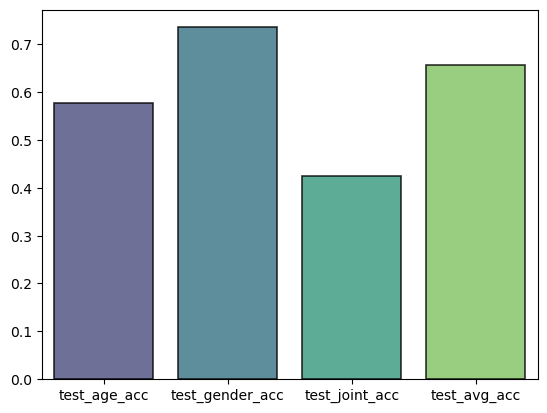

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
acc_r2 = {k: v for k, v in results_r2.items() if "acc" in k}
f1_r2 = {k: v for k, v in results_r2.items() if "f1" in k}
sns.barplot(
    x=list(acc_r2.keys()), 
    y=list(acc_r2.values()),
    hue=list(acc_r2.keys()),
    legend=False,
    palette="viridis", 
    alpha=0.8,
    edgecolor='black',      
    linewidth=1.2,               
    capsize=0.1  
)
plt.show()

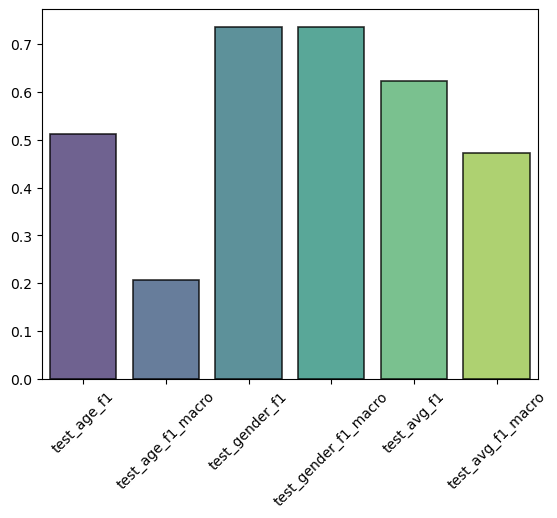

In [70]:
sns.barplot(
    x=list(f1_r2.keys()), 
    y=list(f1_r2.values()),
    hue=list(f1_r2.keys()),
    legend=False,
    palette="viridis", 
    alpha=0.8,
    edgecolor='black',      
    linewidth=1.2,               
    capsize=0.1  
)
plt.xticks(rotation=45)
plt.show()